<a href="https://colab.research.google.com/github/avinashkrishnan2020/Coursera_Capstone/blob/master/Segmenting_%26_Clustering_Neighborhoods_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Segmenting and clustering neighborhoods in Toronto, Canada**




Here, we are going to analyze some of the top venues in some of the neighborhoods of Toronto, Canada using the Foursquare API. 

We then segment and cluster the neighborhoods using K-means algorithm based on the venues in each of the neighborhoods.


Submission sections have been marked as 'SUBMISSION-1', 'SUBMISSION-2' and 'SUBMISSION-3'

In [213]:
# Import essential libraries
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import requests
import urllib.request
from urllib.request import urlopen
import time
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

# OBTAINING NEIGHBORHOOD AND POSTAL CODE DETAILS
A list of boroughs and neighborhoods along with their corresponding postal codes can be obtained from the wikiedia url: 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

The page is then scraped to find the table with the required details usinf 'BeautifulSoup' API.

In [214]:
# Url for obtaining the table consisting of postal codes,
# boroughs and neighbourhoods in Canada
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_page = urlopen(url)

'html_page' object created above contains the html code of the webpage we scraped from wikipedia.

We then create an instance of BeautifulSoup and to find the table containing 
all the details we require.

In [215]:
# BeautifulSoup instance
soup = BeautifulSoup(html_page, 'html.parser')

# Find tables in the html page
tables = soup.find_all('table')

'tables' consists of all the tables avalable in the webpage. The table we require is the first one in the page and hence at index 0 in 'tables' object.

We then access all the rows of the table with the find_all() method.

In [216]:
# The first table in the page corresponds to the
# table consisting of postal codes and neighborhoods
toronto_PC = tables[0]

In [217]:
# Find the header row of the table
header_row = (toronto_PC.find_all('tr')[0]).find_all('th')

In [218]:
# Data Rows
data_rows = toronto_PC.find_all('tr')

We then create new lists postal_code, borough and neighborhood to add their corresponding entries in each row of the table. 

A new dictionary is made with these lists and then converted to a DataFrame.

In [219]:
# Create a dataframe with columns postal code, borough and neighborhoood
postal_code = []
borough = []
neighborhood = []

for row in data_rows[1:]:
    data_list = [] # data_list is used to store cell value of each row.
    data = row.find_all('td') 
    
    for item in data:
        data_list.append(item.text.strip())
    
    postal_code.append(data_list[0]) # Add postal code to postal_code list
    borough.append(data_list[1]) # Add borough to borough list
    neighborhood.append(data_list[2]) # Add the neighborhood to neighborhood list



In [220]:
# Create a new dictionary with data collected from the table
postal_codes_dict = {'PostalCode':postal_code , 'Borough' : borough , 'Neighborhood' : neighborhood}

In [221]:
# Create a dataframe from dictionary
toronto_data = pd.DataFrame(postal_codes_dict)

#SUBMISSION-1

Remove all rows having 'Not assigned' as their value under the 'Borough' column.

In [222]:
# Remove rows having borough as 'Not Assigned'
toronto_data = toronto_data[toronto_data['Borough'] != 'Not assigned']
toronto_data.reset_index(drop=True)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [223]:
# Shape of resulting dataframe and number of rows
print(" Shape of the dataframe obtained is: {}".format(toronto_data.shape))
print(" Number of rows: {}".format(toronto_data.shape[0]))

 Shape of the dataframe obtained is: (103, 3)
 Number of rows: 103


#ADD LATITUDE AND LONGITUDE DATA FOR EACH ROW

Before we mark the neighborhoods using folium, we must find the latitude and longitudes for each one of them.

These coordinates can be obtained from the url: http://cocl.us/Geospatial_data

The csv file is downloaded and saved as 'geospatial_data.csv'.

This csv file is then read and converted to a pandas DataFrame usinf pandas.DataFrame()

In [224]:
# Download the csv file of postal codes and respective (latitude,longitude) details.
# Name the file as 'geospatial_data.csv'
!wget -q -O 'geospatial_data.csv' http://cocl.us/Geospatial_data

In [225]:
# Create a dataframe from csv file downloaded
with open('geospatial_data.csv') as geospatial_json:
    geospatial_data = pd.read_csv(geospatial_json)

Latitude and Longitude details are obtained for each Postal code.

In [226]:
# Show sample of the geospatial dataframe
geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We now add the Latitude and Longitude columns to the 'toronto_data' dataframe we created initially.

In [227]:
# Make postal code as the index for geospatial dataframe
geospatial_data.index = geospatial_data['Postal Code']

In [228]:
# Create a new dataframe having postal codes present in 'toronto_data' dataframe and
# along with its corresponding latitude and longitude
lat_long_df = geospatial_data.loc[toronto_data['PostalCode'], ['Latitude','Longitude']]
lat_long_df.reset_index(drop = True)
latitude = list(lat_long_df['Latitude'])
longitude = list(lat_long_df['Longitude'])

In [229]:
# Add the latitude and longitude data to toronto_data df
toronto_data['Latitude'] = latitude
toronto_data['Longitude'] = longitude

#SUBMISSION-2

In [230]:
# Checkout the modified dataframe
toronto_data.reset_index(drop=True, inplace=True)
toronto_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [231]:
# Shape of resulting dataframe and number of rows
print(" Shape of the dataframe obtained is: {}".format(toronto_data.shape))
print(" Number of rows: {}".format(toronto_data.shape[0]))

 Shape of the dataframe obtained is: (103, 5)
 Number of rows: 103


As we can see above, coordinates for each postal code reagions have been identified and added to the toronto_data dataframe.

We now visualize the boroughs/Neighborhoods using folium.

#VISUALIZE BOROUGHS AND NEIGHBORHOODS IN MAP

We now visualize the neighborhoods/boroughs in Toronto using folium.

In [232]:
# Map instance of Toronto
toronto_map = folium.Map(
    [43.651070,-79.347015],
    zoom_start = 10
)

In [233]:
# Visualize Map of Toronto
toronto_map

We now add circle markers at each borough.

Borough name will be popup on clicking the circle markers.

In [234]:
# Add markers at the boroughs/Neighborhoods
for borough, latitude, longitude in zip(toronto_data['Borough'],toronto_data['Latitude'],toronto_data['Longitude']):
    label = folium.Popup(borough, parse_html = True)
    folium.CircleMarker(
        location=[latitude,longitude],
        radius=10,
        popup=label,
        fill = True
    ).add_to(toronto_map)

View the Map with circle markers

In [235]:
toronto_map

# SEGMENTING AND CLUSTERING NEIGHBORHOODS IN TORONTO




Create objects to  store the foursquare client id, client secret as well as the version to use.

In [236]:
# Hide client id and client secret
clientId = "ABC"
clientSecret = "ABC"
version = "20180605"

#SUBMISSION-3

(Cluster Map attached towards end under heading "CLUSTER MAP")

Include rows in toronto_data dataframe which have only 'Toronto' in their borough names and explore venues of these neighborhoods only.

In [237]:
# Include row in toronto_data where the Borough contins 'Toronto'
toronto_data = toronto_data[toronto_data['Borough'].str.contains('Toronto')]

In [238]:
# Checkout the new dataframe
toronto_data.reset_index(drop=True, inplace = True)
toronto_data.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


# BEFORE WE EXPLORE THE VENUES IN ALL NEIGHBORHOODS, LET'S FIRST TRY OUT FOR ONE OF THEM

# EXPLORE VENUES IN ONE OF THE NEIGHBORHOODS OF TORONTO.

For this, let's consider the neighborhoods corresponding to the 5th row in toronto_data dataframe.

In [239]:
# Explore the 5th Neighborhood in the data frame
neighborhood_latitude = toronto_data.loc[4, 'Latitude']
neighborhood_longitude = toronto_data.loc[4, 'Longitude']

neighborhood_name = toronto_data.loc[4, 'Neighborhood']

First, we set the radius within which we found out the nearby venues for the particular neighborhood and also set the number of venues limit.

The values are then formatted into the foursquare url which will be used to obtain the venues in the neighborhood.

In [240]:
# Set the radius and number of venues limit
radius = 1000
limit = 100

foursquare_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(clientId, clientSecret, version,
    neighborhood_latitude, neighborhood_longitude, radius, limit)


We call the foursquare API service using requests.get() and store the json response obtained into result_json object.

In [241]:
result_json = requests.get(foursquare_url).json()
result_json

{'meta': {'code': 200, 'requestId': '5eef93a09fcb92001bf6213d'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4bd461bc77b29c74a07d9282-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/hikingtrail_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d159941735',
         'name': 'Trail',
         'pluralName': 'Trails',
         'primary': True,
         'shortName': 'Trail'}],
       'id': '4bd461bc77b29c74a07d9282',
       'location': {'address': 'Glen Manor',
        'cc': 'CA',
        'city': 'Toronto',
        'country': 'Canada',
        'crossStreet': 'Queen St.',
        'distance': 89,
        'formattedAddress': ['Glen Manor (Queen St.)', 'Toronto ON', 'Canada'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67682

Iterate through the json response obtained to find the venues and store all the details of nearby venues into nearby_venues object.

pandas.json_normalize() is used to convert the json to a dataframe

In [242]:
venues = result_json['response']['groups'][0]['items']

# Venues near the beaches (dataframe)  
nearby_venues = pd.json_normalize(venues)
nearby_venues.head()


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.postalCode,venue.venuePage.id,venue.events.count,venue.events.summary,venue.location.neighborhood
0,e-0-4bd461bc77b29c74a07d9282-0,0,"[{'summary': 'This spot is popular', 'type': '...",4bd461bc77b29c74a07d9282,Glen Manor Ravine,Glen Manor,Queen St.,43.676821,-79.293942,"[{'label': 'display', 'lat': 43.67682094413784...",89,CA,Toronto,ON,Canada,"[Glen Manor (Queen St.), Toronto ON, Canada]","[{'id': '4bf58dd8d48988d159941735', 'name': 'T...",0,[],NaN,NaN,NaN,NaN,NaN
1,e-0-4f5a855be4b0a4baa1ae0063-1,0,"[{'summary': 'This spot is popular', 'type': '...",4f5a855be4b0a4baa1ae0063,Tori's Bakeshop,2188 Queen Street E,Balsam Ave,43.672114,-79.290331,"[{'label': 'display', 'lat': 43.67211394726956...",519,CA,Toronto,ON,Canada,"[2188 Queen Street E (Balsam Ave), Toronto ON ...","[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",0,[],M431E6,43778861,NaN,NaN,NaN
2,e-0-4c0e40c0c700c9b6e185a3dd-2,0,"[{'summary': 'This spot is popular', 'type': '...",4c0e40c0c700c9b6e185a3dd,Beaches Bake Shop,900 Kingston Rd.,Pickering Ave.,43.680363,-79.289692,"[{'label': 'display', 'lat': 43.68036312619922...",520,CA,Toronto,ON,Canada,"[900 Kingston Rd. (Pickering Ave.), Toronto ON...","[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",0,[],NaN,NaN,NaN,NaN,NaN
3,e-0-4b37c839f964a5200e4625e3-3,0,"[{'summary': 'This spot is popular', 'type': '...",4b37c839f964a5200e4625e3,Ed's Real Scoop,2224 Queen St. E,btwn Spruce Hill & Beech,43.672630,-79.287993,"[{'label': 'display', 'lat': 43.67262965222451...",580,CA,Toronto,ON,Canada,"[2224 Queen St. E (btwn Spruce Hill & Beech), ...","[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",0,[],M4E 1E9,NaN,NaN,NaN,NaN
4,e-0-5286b7dd498e8b747c1dfe71-4,0,"[{'summary': 'This spot is popular', 'type': '...",5286b7dd498e8b747c1dfe71,The Beech Tree,924 Kingston Rd.,NaN,43.680493,-79.288846,"[{'label': 'display', 'lat': 43.680493, 'lng':...",570,CA,Toronto,ON,Canada,"[924 Kingston Rd., Toronto ON, Canada]","[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",0,[],NaN,NaN,NaN,NaN,NaN


Define a method to find the category name of the venue from the dataframe that is passed it.

In [243]:
# Method to get venue category
def get_venue_category(dataframe):
    try:
        categories = dataframe['categories']
    except:
        categories = dataframe['venue.categories']
        
    if len(categories) == 0:
        return None
    else:
        return categories[0]['name']

Create a list of columns that we require and include only those columns in the 
nearby_venues dataframe we just created.

The dataframe is then passed to the get_venue_category() method to extract the category name of the venue.

In [244]:
# List of columns required from dataframe
columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, columns]

# Get category for each venue
nearby_venues['venue.categories'] = nearby_venues.apply(get_venue_category, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,Tori's Bakeshop,Vegetarian / Vegan Restaurant,43.672114,-79.290331
2,Beaches Bake Shop,Bakery,43.680363,-79.289692
3,Ed's Real Scoop,Ice Cream Shop,43.672630,-79.287993
4,The Beech Tree,Gastropub,43.680493,-79.288846


#EXPLORE VENUES OF ALL NEIGHBORHOODS IN TORONTO

Create a method to find the nearby venues given the latitude and longitude.

result_json object contains the venue detail json which is then converted to the nearby_venues dataframe.

The method then return the dataframe nearby_venues.

In [245]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        radius = 1000 # set 1km radius
        limit = 100 # Limit then number of nearby venues to 100

        foursquare_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(clientId, clientSecret, version,
                lat, lng, radius, limit)
            
        # Get the json response
        result_json = requests.get(foursquare_url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues.append([(
            name, 
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']) for venue in result_json])

    nearby_venues = pd.DataFrame([item for venue_list in venues for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

toronto_venues contains the nearby venues of all the neighborhoods in toronto_data dataframe. The nearby venues are obtained by calling the method getNearbyVenues() to which we pass the latitude, longitude details as well as the neighborhood name.

In [246]:
# Nearby venues for each neighborhood
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )


Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


We now group the toronto_venues by the neighborhood.

In [247]:
# Group the dataframe by neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,100,100,100,100,100,100
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",47,47,47,47,47,47
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,100,100,100,100,100,100
Christie,100,100,100,100,100,100
Church and Wellesley,100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,100,100,100,100,100,100


Let us now utilise one hot encoding which is used to encode categorical data.


In [248]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column 
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 



We now group the toronto_onehot dataframe by their 'Neighborhood'and find out how often each of the categories appear in each of the neighborhood by finding out their mean.

In [249]:
# toronto_onehot grouped by neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,...,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Berczy Park,0.00,0.000000,0.010000,0.0,0.0,0.0,0.0,0.01,0.00,0.000000,0.0,0.00,0.0,0.0,0.010000,0.0,0.030000,0.0,0.000000,0.0,0.0,0.01,0.010000,0.00,0.02,0.0,0.0,0.0,0.010000,0.0,0.00,0.0,0.0,0.0,0.020000,0.00000,0.0,0.01,0.0,...,0.01,0.0,0.0,0.010000,0.0,0.0,0.01,0.000000,0.0,0.0,0.01,0.0,0.00,0.00,0.01,0.0,0.0,0.010000,0.00,0.0,0.0,0.00,0.00,0.0,0.000000,0.00,0.01,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.01,0.000000,0.010000,0.0,0.0,0.0,0.0,0.01,0.00,0.020000,0.0,0.01,0.0,0.0,0.000000,0.0,0.040000,0.0,0.050000,0.0,0.0,0.00,0.000000,0.01,0.01,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.010000,0.01000,0.0,0.00,0.0,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.02,0.000000,0.0,0.0,0.00,0.0,0.00,0.01,0.01,0.0,0.0,0.000000,0.01,0.0,0.0,0.02,0.03,0.0,0.000000,0.01,0.00,0.0,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,"Business reply mail Processing Centre, South C...",0.00,0.000000,0.021277,0.0,0.0,0.0,0.0,0.00,0.00,0.021277,0.0,0.00,0.0,0.0,0.021277,0.0,0.042553,0.0,0.021277,0.0,0.0,0.00,0.021277,0.00,0.00,0.0,0.0,0.0,0.021277,0.0,0.00,0.0,0.0,0.0,0.021277,0.06383,0.0,0.00,0.0,...,0.00,0.0,0.0,0.021277,0.0,0.0,0.00,0.042553,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.021277,0.00,0.0,0.0,0.00,0.00,0.0,0.000000,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.00,0.071429,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.00000,0.0,0.00,0.0,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.00,0.0,0.071429,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,Central Bay Street,0.00,0.000000,0.010000,0.0,0.0,0.0,0.0,0.03,0.01,0.020000,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.00,0.01,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.0,0.010000,0.00000,0.0,0.02,0.0,...,0.00,0.0,0.0,0.010000,0.0,0.0,0.01,0.040000,0.0,0.0,0.00,0.0,0.01,0.00,0.01,0.0,0.0,0.010000,0.02,0.0,0.0,0.00,0.00,0.0,0.000000,0.00,0.00,0.0,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0


Let us now print out the top 5 categories in each of the neighborhood.

We take each neighborhood and arrange categories in descending order of their frequency of appearance.

In [250]:
#Print the top 5 venues in each neighborhood
num_top_venues = 5

for neighborhood in toronto_grouped['Neighborhood']:
    print("----" + neighborhood + "----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == neighborhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                 venue  freq
0          Coffee Shop  0.12
1                 Café  0.06
2                Hotel  0.05
3           Restaurant  0.04
4  Japanese Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
         venue  freq
0         Café  0.07
1  Coffee Shop  0.06
2          Bar  0.05
3   Restaurant  0.05
4       Bakery  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
              venue  freq
0              Park  0.09
1       Coffee Shop  0.06
2           Brewery  0.06
3       Pizza Place  0.06
4  Sushi Restaurant  0.04


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
             venue  freq
0  Harbor / Marina  0.14
1             Café  0.14
2      Coffee Shop  0.14
3             Park  0.07
4          Airport  0.07


----Central Bay Street----
              venue  freq
0       Coffee Shop  0.08
1  Sushi Restaurant  0.04


Define a method to return top venues in a neighborhood

In [251]:
# Method to return the top venues in a neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Get the top 10 venues for each neighborhood.

In [252]:
# Define the max number we need
num_top_venues = 10

# Suffix for 1st,2nd..
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for row_num in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[row_num, 1:] = return_most_common_venues(toronto_grouped.iloc[row_num, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Café,Hotel,Park,Japanese Restaurant,Restaurant,Bakery,Beer Bar,Liquor Store,Breakfast Spot
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Restaurant,Bar,Furniture / Home Store,Bakery,Tibetan Restaurant,Gift Shop,Sandwich Place,Performing Arts Venue
2,"Business reply mail Processing Centre, South C...",Park,Coffee Shop,Pizza Place,Brewery,Sushi Restaurant,Bakery,Fast Food Restaurant,Italian Restaurant,Electronics Store,Farmers Market
3,"CN Tower, King and Spadina, Railway Lands, Har...",Café,Harbor / Marina,Coffee Shop,Dance Studio,Scenic Lookout,Dog Run,Track,Park,Sculpture Garden,Garden
4,Central Bay Street,Coffee Shop,Sushi Restaurant,Ramen Restaurant,Park,Art Gallery,Café,Japanese Restaurant,Bubble Tea Shop,Mexican Restaurant,Gastropub


Let us now cluster the neighborhooods using K-Means clustering method.

In [253]:
# set number of clusters
kclusters = 5

# Drop Neighborhood column as we require only the common categories columns.
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 1, 3, 2, 0, 2, 2, 1, 1], dtype=int32)

In [254]:
# add clustering labels column to dataframe
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



In [255]:
# Merge other details such as latitiude, longitude, borough etc.
toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Diner,Theater,Pub,Café,Park,Italian Restaurant,Breakfast Spot,Bakery,Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Park,Burger Joint,Ramen Restaurant,Café,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Men's Store,Ice Cream Shop
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Coffee Shop,Gastropub,Japanese Restaurant,Italian Restaurant,Theater,Ramen Restaurant,Café,Hotel,Gay Bar,Creperie
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Restaurant,Italian Restaurant,Gastropub,Furniture / Home Store,Japanese Restaurant,Bookstore,Seafood Restaurant,Tea Room
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pizza Place,Coffee Shop,Pub,Beach,Breakfast Spot,Japanese Restaurant,Bakery,Ice Cream Shop,Health Food Store,Burger Joint


#CLUSTER MAP

In [256]:
# create map of the clusters
map_clusters = folium.Map(location=[43.651070,-79.347015], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add cluster markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let us name the clusters as follows:
- cluster-0 as RED CLUSTER
- cluster-1 as VIOLET CLUSTER
- cluster-2 as BLUE CLUSTER
- cluster-3 as GREEN CLUSTER
- cluster-4 as ORANGE CLUSTER

#ANALYZING THE CLUSTERS

In [257]:
import matplotlib.pyplot as plt


Define a method that returns a dataframe which conveys how frequent a particular category occurs in a given cluster.

In [258]:
def get_category_frequency_for_cluster(cluster):
    categories = []
    for index in range(0, cluster.shape[0]):
        row = cluster.iloc[index, 6:16]
        for item in row.iteritems():
            categories.append(item[1]) 

    cluster_freq = pd.DataFrame((pd.DataFrame(categories))[0].value_counts())
    cluster_freq.reset_index(drop=False, inplace=True)
    cluster_freq
    cluster_freq.columns = ['category','frequency'] 

    return cluster_freq

Define a method to plot the histogram of each venue category in a cluster

In [259]:
def plot_cluster_freq(dataframe, title):
    f,ax = plt.subplots(figsize=(20,8))
    plt.bar(dataframe['category'], dataframe['frequency'])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.show()

**Analysis of each cluster** :

CLUSTER RED

Number of categories = 41


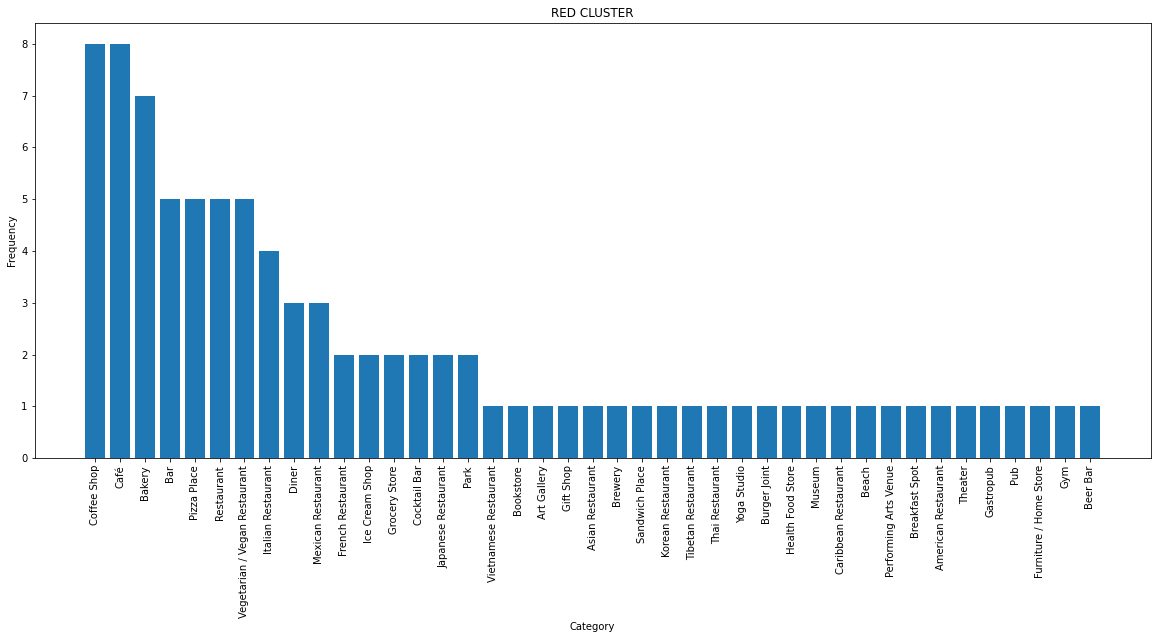

In [260]:
# Red cluster
cluster_red = toronto_merged[toronto_merged['Cluster Labels']==0]
cluster_red.reset_index(drop=True, inplace=True)
cluster_red_freq = get_category_frequency_for_cluster(cluster_red)
print("Number of categories = {}".format(len(list(cluster_red_freq['category']))))
plot_cluster_freq(cluster_red_freq, 'RED CLUSTER')

In [261]:
columns = ['Neighborhood','1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue']

In [262]:
# cluster-0 dataframe
cluster_red[columns]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,Pizza Place,Coffee Shop,Pub,Beach,Breakfast Spot,Japanese Restaurant,Bakery,Ice Cream Shop,Health Food Store,Burger Joint
1,Christie,Korean Restaurant,Coffee Shop,Café,Grocery Store,Cocktail Bar,Mexican Restaurant,Pizza Place,Ice Cream Shop,Diner,Vegetarian / Vegan Restaurant
2,"Little Portugal, Trinity",Café,Bar,Restaurant,Vegetarian / Vegan Restaurant,Bakery,Cocktail Bar,Italian Restaurant,Asian Restaurant,Coffee Shop,Pizza Place
3,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Restaurant,Bar,Furniture / Home Store,Bakery,Tibetan Restaurant,Gift Shop,Sandwich Place,Performing Arts Venue
4,Studio District,Coffee Shop,Bar,Café,American Restaurant,Bakery,Vietnamese Restaurant,Brewery,Diner,French Restaurant,Italian Restaurant
5,"The Annex, North Midtown, Yorkville",Coffee Shop,Vegetarian / Vegan Restaurant,Café,Italian Restaurant,Bakery,Pizza Place,Museum,Gym,Restaurant,Grocery Store
6,"University of Toronto, Harbord",Café,Bakery,Vegetarian / Vegan Restaurant,Bar,Coffee Shop,Bookstore,Mexican Restaurant,Restaurant,Beer Bar,Pizza Place
7,"Kensington Market, Chinatown, Grange Park",Café,Bar,Vegetarian / Vegan Restaurant,Art Gallery,Coffee Shop,Park,Mexican Restaurant,Bakery,Yoga Studio,French Restaurant
8,"St. James Town, Cabbagetown",Café,Diner,Park,Gastropub,Japanese Restaurant,Caribbean Restaurant,Italian Restaurant,Theater,Thai Restaurant,Restaurant


CLUSTER VIOLET

Number of categories = 45


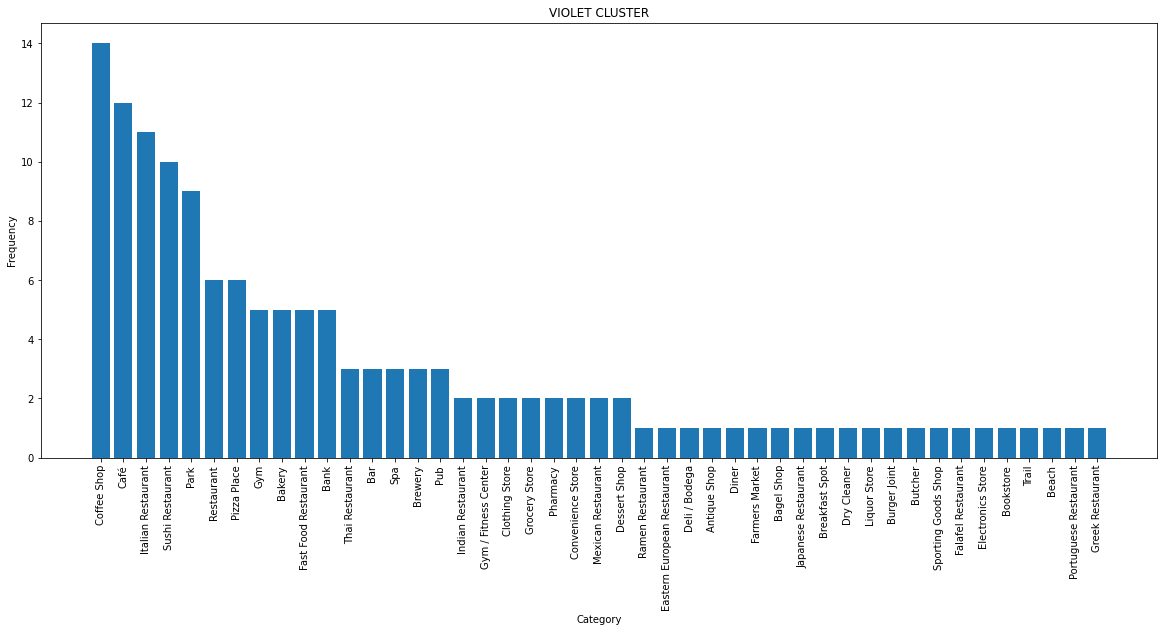

In [263]:
# Violet cluster
cluster_violet = toronto_merged[toronto_merged['Cluster Labels']==1]
cluster_violet.reset_index(drop=True, inplace=True)
cluster_violet_freq = get_category_frequency_for_cluster(cluster_violet)
print("Number of categories = {}".format(len(list(cluster_violet_freq['category']))))
plot_cluster_freq(cluster_violet_freq, "VIOLET CLUSTER")

In [264]:
# cluster-1 dataframe
cluster_violet[columns]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Dufferin, Dovercourt Village",Café,Coffee Shop,Park,Sushi Restaurant,Italian Restaurant,Portuguese Restaurant,Bar,Bakery,Convenience Store,Brewery
1,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Café,Pub,Fast Food Restaurant,Italian Restaurant,Bank,Spa,Bookstore,Ramen Restaurant
2,"India Bazaar, The Beaches West",Indian Restaurant,Coffee Shop,Beach,Café,Fast Food Restaurant,Restaurant,Butcher,Bakery,Park,Brewery
3,Roselawn,Coffee Shop,Italian Restaurant,Pharmacy,Sushi Restaurant,Gym,Café,Bank,Dry Cleaner,Clothing Store,Japanese Restaurant
4,Davisville North,Coffee Shop,Italian Restaurant,Restaurant,Café,Fast Food Restaurant,Dessert Shop,Sushi Restaurant,Pizza Place,Gym,Mexican Restaurant
5,"Forest Hill North & West, Forest Hill Road Park",Park,Coffee Shop,Trail,Café,Bank,Sushi Restaurant,Liquor Store,Burger Joint,Pharmacy,Gym / Fitness Center
6,"High Park, The Junction South",Café,Bar,Coffee Shop,Italian Restaurant,Thai Restaurant,Convenience Store,Sushi Restaurant,Antique Shop,Park,Deli / Bodega
7,"North Toronto West, Lawrence Park",Coffee Shop,Italian Restaurant,Park,Sporting Goods Shop,Café,Restaurant,Mexican Restaurant,Diner,Clothing Store,Spa
8,"Parkdale, Roncesvalles",Coffee Shop,Café,Sushi Restaurant,Pizza Place,Breakfast Spot,Bar,Bakery,Eastern European Restaurant,Pub,Restaurant
9,Davisville,Italian Restaurant,Sushi Restaurant,Coffee Shop,Café,Restaurant,Indian Restaurant,Dessert Shop,Fast Food Restaurant,Pizza Place,Gym


CLUSTER BLUE

Number of categories = 42


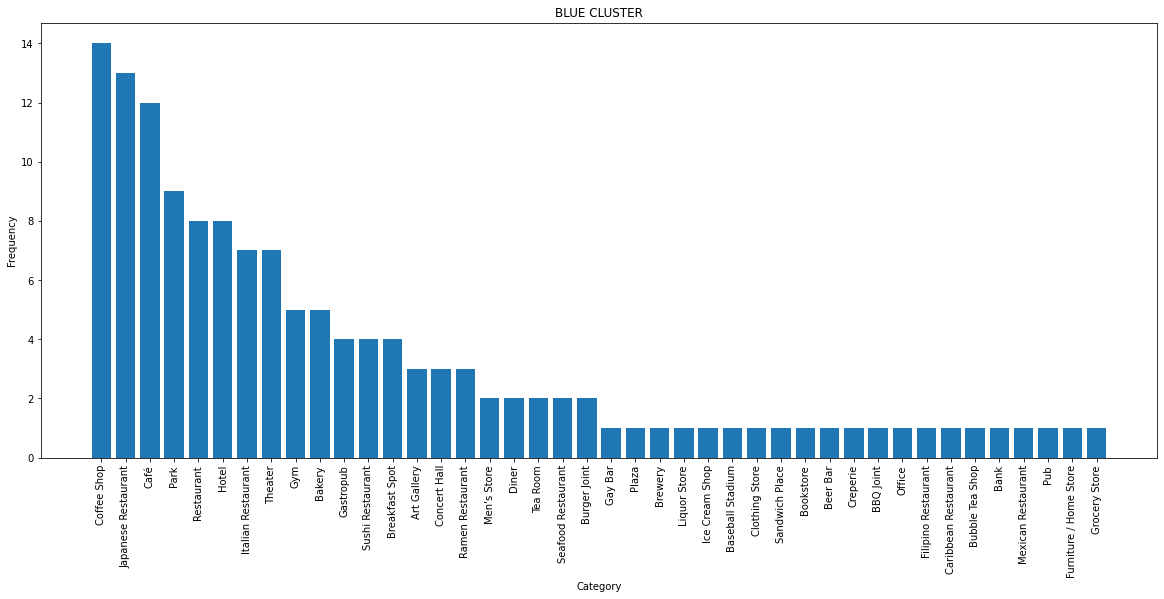

In [265]:
#Blue cluster
cluster_blue = toronto_merged[toronto_merged['Cluster Labels']==2]
cluster_blue.reset_index(drop=True, inplace=True)
cluster_blue_freq = get_category_frequency_for_cluster(cluster_blue)
print("Number of categories = {}".format(len(list(cluster_blue_freq['category']))))
plot_cluster_freq(cluster_blue_freq, "BLUE CLUSTER")

In [266]:
# cluster_2 dataframe
cluster_blue[columns]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",Coffee Shop,Diner,Theater,Pub,Café,Park,Italian Restaurant,Breakfast Spot,Bakery,Restaurant
1,"Queen's Park, Ontario Provincial Government",Coffee Shop,Park,Burger Joint,Ramen Restaurant,Café,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Men's Store,Ice Cream Shop
2,"Garden District, Ryerson",Coffee Shop,Gastropub,Japanese Restaurant,Italian Restaurant,Theater,Ramen Restaurant,Café,Hotel,Gay Bar,Creperie
3,St. James Town,Coffee Shop,Café,Restaurant,Italian Restaurant,Gastropub,Furniture / Home Store,Japanese Restaurant,Bookstore,Seafood Restaurant,Tea Room
4,Berczy Park,Coffee Shop,Café,Hotel,Park,Japanese Restaurant,Restaurant,Bakery,Beer Bar,Liquor Store,Breakfast Spot
5,Central Bay Street,Coffee Shop,Sushi Restaurant,Ramen Restaurant,Park,Art Gallery,Café,Japanese Restaurant,Bubble Tea Shop,Mexican Restaurant,Gastropub
6,"Richmond, Adelaide, King",Coffee Shop,Café,Hotel,Theater,Japanese Restaurant,Art Gallery,Tea Room,Gym,Sushi Restaurant,Italian Restaurant
7,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Hotel,Café,Park,Brewery,Theater,Japanese Restaurant,Gym,Baseball Stadium,Bakery
8,"Toronto Dominion Centre, Design Exchange",Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Italian Restaurant,Concert Hall,Theater,Park,Gym
9,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Bakery,Concert Hall,Seafood Restaurant,Gym,Theater


CLUSTER GREEN

Number of categories = 10


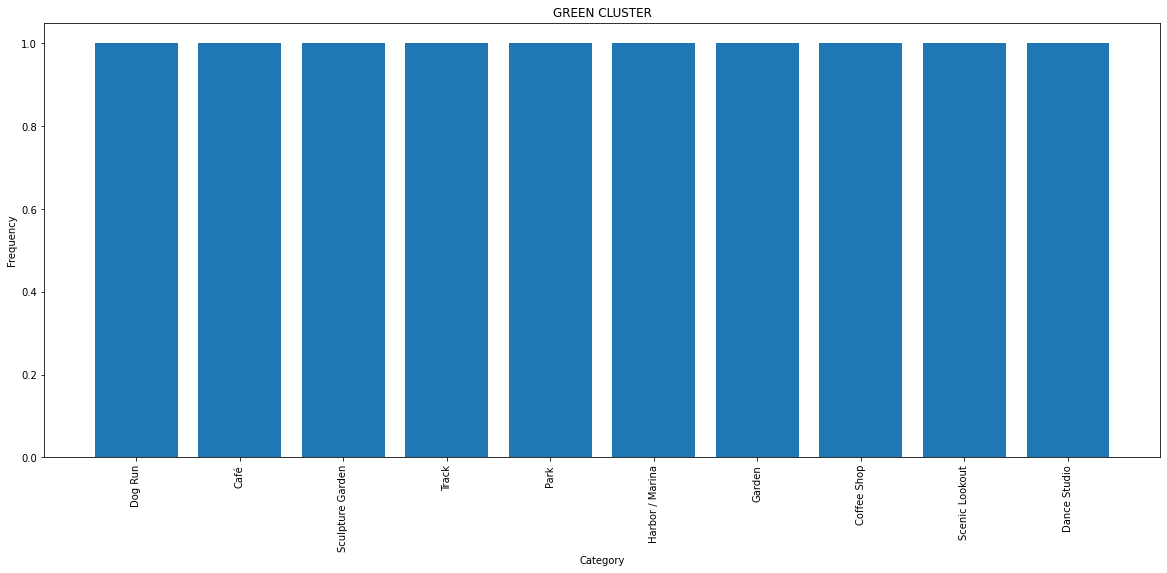

In [267]:
# Green Cluster
cluster_green = toronto_merged[toronto_merged['Cluster Labels']==3]
cluster_green.reset_index(drop=True, inplace=True)
cluster_green_freq = get_category_frequency_for_cluster(cluster_green)
print("Number of categories = {}".format(len(list(cluster_green_freq['category']))))
plot_cluster_freq(cluster_green_freq, "GREEN CLUSTER")

In [268]:
# cluster-3 dataframe
cluster_green[columns]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"CN Tower, King and Spadina, Railway Lands, Har...",Café,Harbor / Marina,Coffee Shop,Dance Studio,Scenic Lookout,Dog Run,Track,Park,Sculpture Garden,Garden


CLUSTER ORANGE

Number of categories = 10


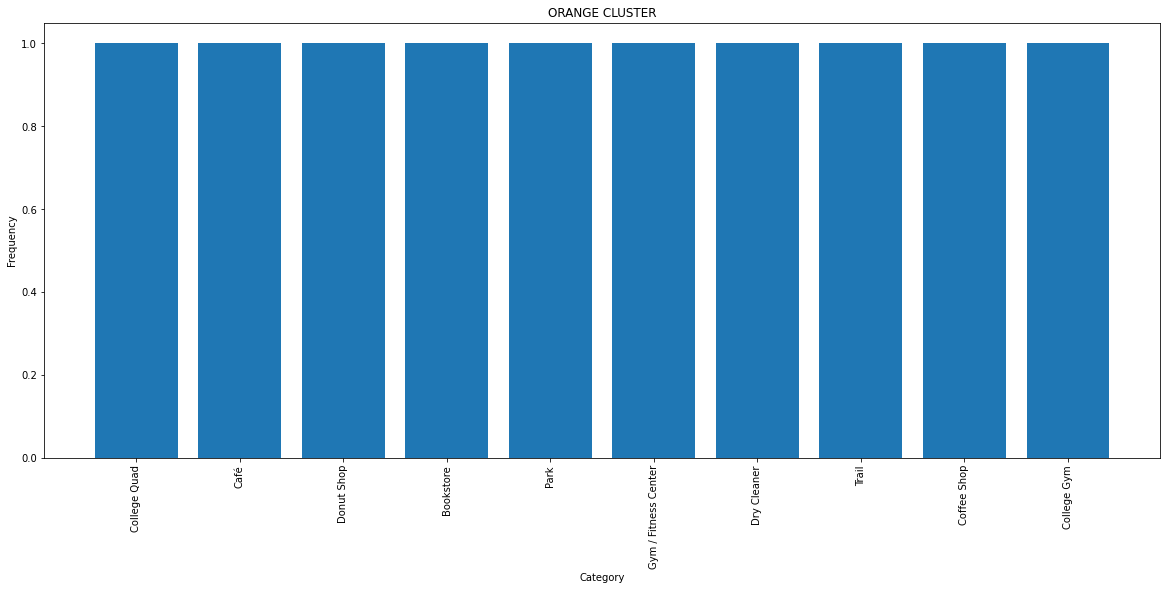

In [269]:
#Orange cluster
cluster_orange = toronto_merged[toronto_merged['Cluster Labels']==4]
cluster_orange.reset_index(drop=True, inplace=True)
cluster_orange_freq = get_category_frequency_for_cluster(cluster_orange)
print("Number of categories = {}".format(len(list(cluster_orange_freq['category']))))
plot_cluster_freq(cluster_orange_freq, "ORANGE CLUSTER")

In [270]:
# cluster-4 dataframe
cluster_orange[columns]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lawrence Park,Coffee Shop,Café,Bookstore,Park,Gym / Fitness Center,College Quad,College Gym,Trail,Donut Shop,Dry Cleaner


#RED CLUSTER (Cluster-0) 

The neighborhoods clustered as Red mostly have restaurants of various cuisines from different parts of the world. There's american, Italian, Portuguese.... you name it.

Along with diverse cuisines, these areas also have other attractions such as beaches, museums, and theatres. Hence, these would be ideal locations to visit for tourists who enjoy arts and history as well as for those who want to tingle their taste buds with flavours around the world.

#VIOLET CLUSTER (Cluster-1)

These neighborhoods are almost similar to the Red Cluster. 
Although it has a good number of restaurants offering flavours from different parts of the world, it does not outnumber the neighborhoods in red in terms of variety. It also lacks in venues such as theatres, galleries and museums which could be found in the neighborhoods clustered as red.

However, one will be able to find essential stores in these areas which are the most sought after by families or even working bachelors who prefer staying at a locality that has everything nearby. As we can observe from the bar chart, these neighborhoods have pharmacies, sports stores and convenience stores. Along with these, gyms and banks are also available.

#BLUE CLUSTER (Cluster-2)

These are very similar to the violet as well as the red clusters. It's got the essential stores, art galleries and restaurants. However, the choices are limited compared to the other red and violet zones. 

One venue that makes these neighborhoods stand out is the presence of baseball stadiums. Hence it would be an ideal location for baseball fans and families as well.

#GREEN CLUSTER (Cluster-3)

These localities have very limited categories compared to other clusters.
Eventhough it does not provide diversity, it has adequate number of venues for all the categories it provides.

These would be an ideal location for people who want to zone out from the crowded cities and experience the beauty, quietness and calmness of nature. These neighborhoods have plenty of tracks, parks, gardens and and scenic locations and hence is a perfect getaway!

#ORANGE CLUSTER (Cluster-4)
Generally speaking, this cluster is very similar to the green cluster.
The neighborhoods here also have parks, gyms, bookstores and coffee shops. 

The presence of colleeg quad and college gym says about the presence of schools/colleges in these localities. Infact, the neighborhood is well known to have some of the best schools in Toronto.